In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [3]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
# Ny = 1  # 평면 구조
Ny = int(design_region_resolution * design_region_height) + 1


# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [4]:
# 셀 크기 설정
decom_size = width_bot_ag*3
cell_size = mp.Vector3(decom_size, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [5]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )

        
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,

        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [6]:
num_sources = 5
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

In [7]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(decom_size, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

In [8]:
opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        # objective_functions=[J0_02, J30_03, J45_05],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

NameError: name 'J' is not defined

In [32]:
k = np.loadtxt("/home/min/EIDL/Tool/Meep/LGD/LGD Project/Mode decomposition/Kyungmin/Reciprocity/example.txt")
design_variables.update_weights(k)

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


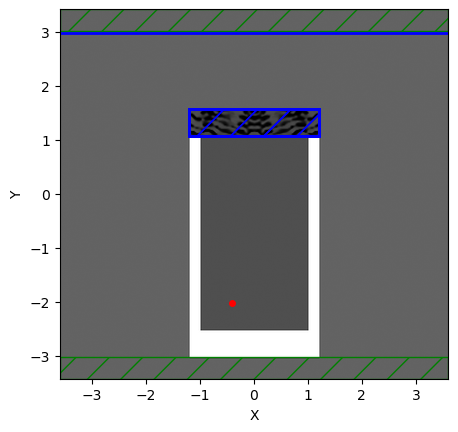

In [ ]:
opt_list[0].plot2D()

on time step 10000 (time=100), 0.424927 s/step
Meep progress: 30.840000000000003/200.0 = 15.4% done in 4.0s, 21.9s to go
on time step 13085 (time=130.85), 0.00129683 s/step
Meep progress: 62.75999999999999/200.0 = 31.4% done in 8.0s, 17.5s to go
on time step 16277 (time=162.77), 0.00125315 s/step
Meep progress: 95.17000000000002/200.0 = 47.6% done in 12.0s, 13.2s to go
on time step 19518 (time=195.18), 0.00123428 s/step


run 1 finished at t = 200.0 (20000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0849001 s
lore

run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.08933 s
lorent

run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.084451 s
loren

run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 3.50475e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.086853 s
loren

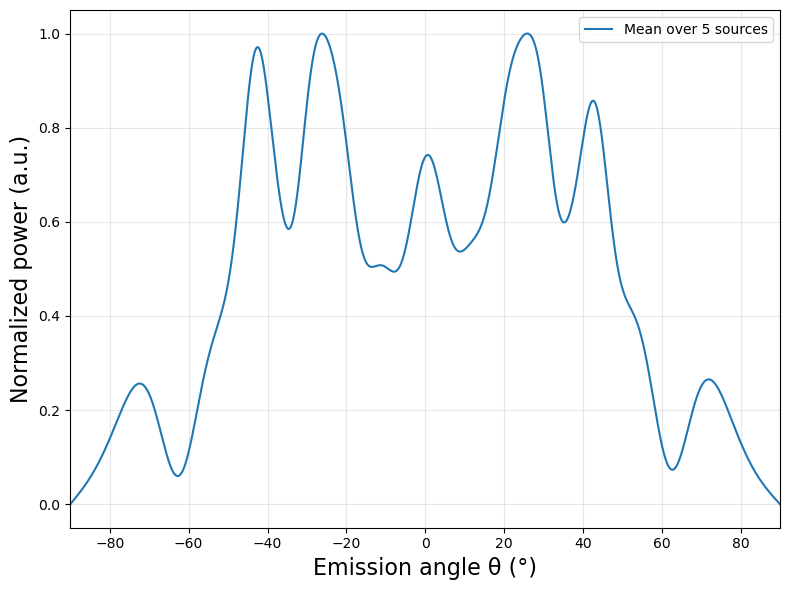

In [ ]:
Ez_dfts = []
for i in range(num_sources):
    dft_i = opt_list[i].sim.add_dft_fields(
        [mp.Ez], fcen, 0, 1,
        center=monitor_position_J, size=monitor_size, yee_grid=True
    )
    opt_list[i].sim.run(until=100)
    Ez_i = np.array(opt_list[i].sim.get_dft_array(dft_i, mp.Ez, 0), dtype=np.complex128)
    Ez_dfts.append(Ez_i)

# 2) 공통 전처리(창함수/좌표/kx 그리드/각도 마스크)
use_window   = True
win_kind     = 'tukey'     # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'        # 'none' or 'Sy'

USE_ANGLE_MASK = True
theta_min_deg  = -90
theta_max_deg  = +90

Ez0 = Ez_dfts[0]
N   = len(Ez0)
dx  = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w      = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)
x      = (np.arange(N) - (N-1)/2) * dx
k0     = 2*np.pi*float(fcen)
kx_grid = np.linspace(-k0, +k0, Nkx)

theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

kx_masked    = kx_grid[ang_mask]
theta_masked = theta_all[ang_mask]

# 3) 각 소스별 각도 스펙트럼 계산 후 평균(비코히어런트: |E|^2 평균)
P_theta_list = []
dk = kx_grid[1]-kx_grid[0]
for Ez in Ez_dfts:
    Ez_win = Ez * w
    Ckx    = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
    Ckx_m  = Ckx[ang_mask]

    if weight.lower() == 'sy':
        P_theta = np.abs(Ckx_m)**2 * np.sqrt(np.maximum(0, 1 - (kx_masked/k0)**2))  # = |E|^2 cosθ
    else:
        P_theta = np.abs(Ckx_m)**2

    P_theta_list.append(P_theta)

P_theta_mean = np.mean(np.vstack(P_theta_list), axis=0)

# (선택) 정규화 후 플롯
plt.figure(figsize=(8,6))
plt.plot(theta_masked, P_theta_mean/np.max(P_theta_mean), label=f"Mean over {num_sources} sources")
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize=16)
plt.ylabel("Normalized power (a.u.)", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


-----------
Initializing structure...
time for choose_chunkdivision = 3.69549e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.089294 s
lorentzian susceptibility: frequency=16.365, gamma=

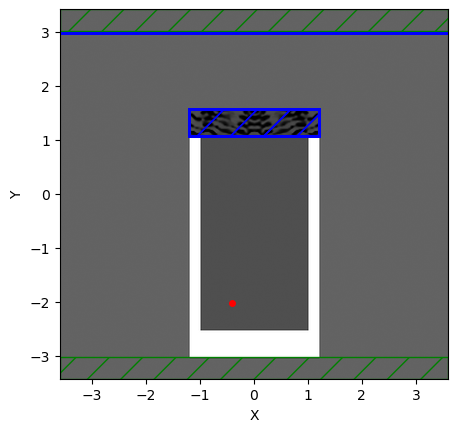

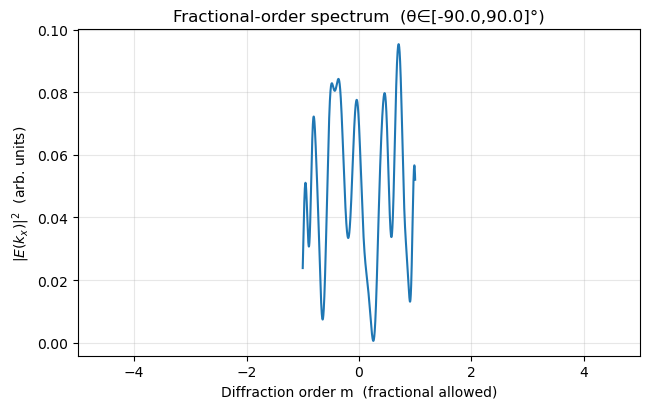

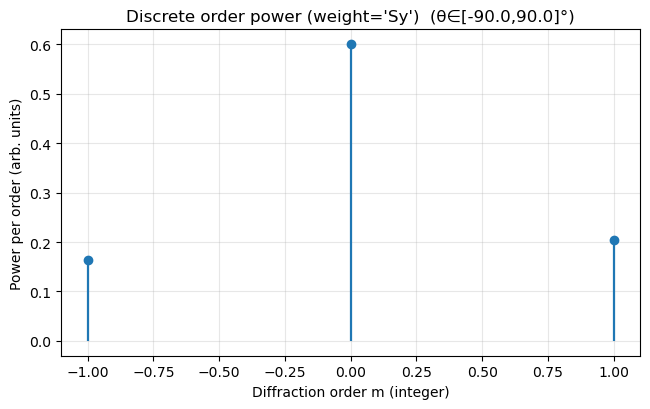

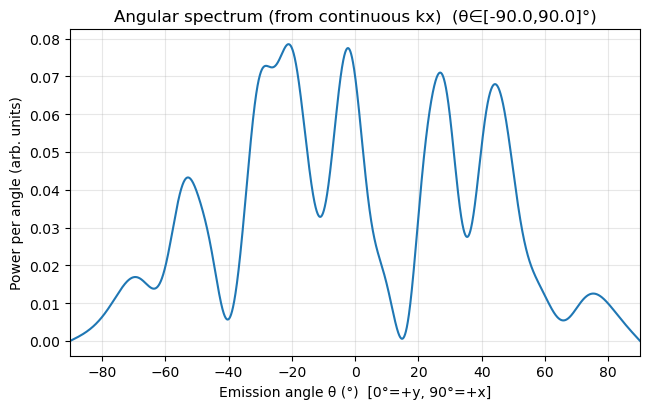

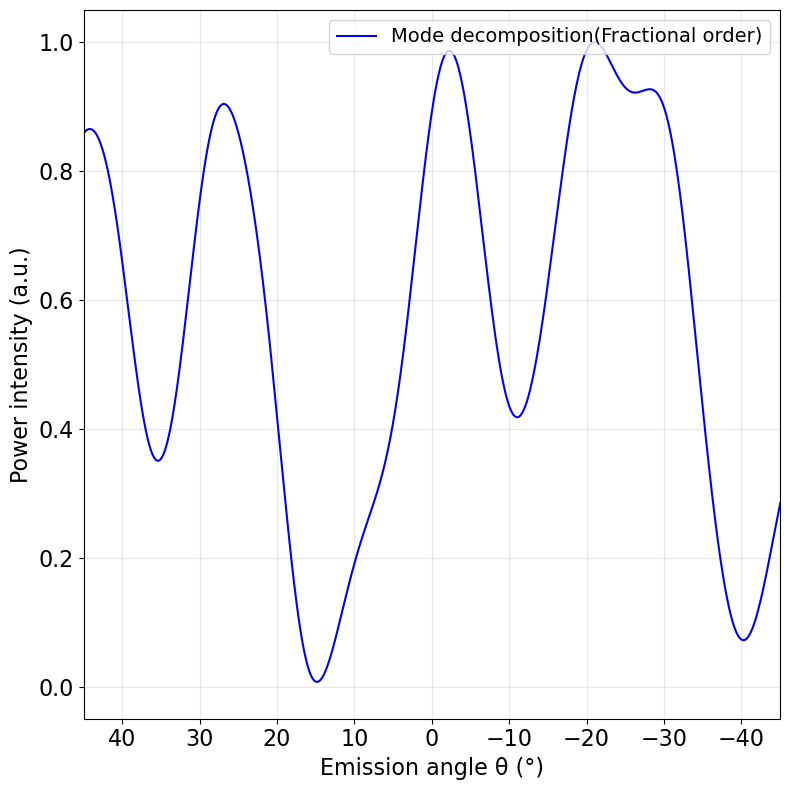

In [ ]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

opt_list[0].sim.run(until=100)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

In [373]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
        
    def reset_momenta(self):
        self.mt = None
        self.vt = None
        self.iter = 0
        
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [374]:
eta_i = 0.5

################ Nx * 1 grating desgin ################ 
def grating_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)

################ Nx * Ny freeform desgin ################ 
def free_mapping(x, eta, beta):
    size_each = Nx * Ny
    v3 = x.reshape(layer_num, size_each).reshape(layer_num, Nx, Ny)

    rho_list = []
    for i in range(layer_num):
        field = v3[i]                               
        proj  = mpa.tanh_projection(field, beta, eta)  
    
        proj = 0.5*(proj[::-1, :] + proj)   # x-축(좌우) 대칭
        rho_list.append(proj.ravel())

    return npa.concatenate(rho_list, axis=0)

In [375]:
############ Beta update ############
def update_beta(evaluation_history, binarization_history, beta):
    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.001 and bin_change2 < 0.001):
            # if beta < 8:
            beta *= 1.2
            # else:
            # beta = beta + np.tanh((beta - 0.5)*0.02)
    return beta


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [3044.5422162256777]
Mean FoM: 3044.542216
Binarization degree: 0.1861


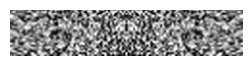


--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [4328.025785054613]
Mean FoM: 4328.025785
Binarization degree: 0.1868


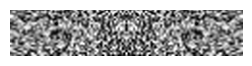


--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [6670.65573113907]
Mean FoM: 6670.655731
Binarization degree: 0.1890


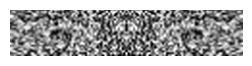


--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [10527.018468848873]
Mean FoM: 10527.018469
Binarization degree: 0.1928


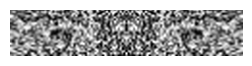


--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [15329.62295313143]
Mean FoM: 15329.622953
Binarization degree: 0.1989


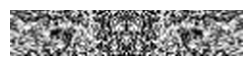


--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [20833.812855205295]
Mean FoM: 20833.812855
Binarization degree: 0.2077


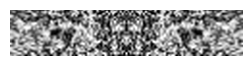


--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [27042.903707910224]
Mean FoM: 27042.903708
Binarization degree: 0.2194


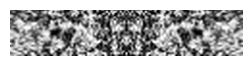


--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [31492.894487878864]
Mean FoM: 31492.894488
Binarization degree: 0.2341


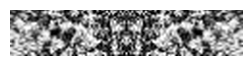


--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [21732.881469988795]
Mean FoM: 21732.881470
Binarization degree: 0.2512


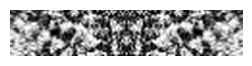


--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [31785.699001933048]
Mean FoM: 31785.699002
Binarization degree: 0.2693


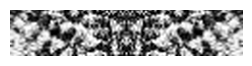


--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [40220.449069604925]
Mean FoM: 40220.449070
Binarization degree: 0.2887


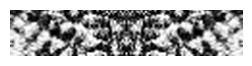


--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [43092.204168750504]
Mean FoM: 43092.204169
Binarization degree: 0.3075


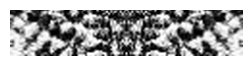


--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [42314.88430533763]
Mean FoM: 42314.884305
Binarization degree: 0.3240


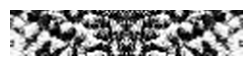


--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [51159.24127753661]
Mean FoM: 51159.241278
Binarization degree: 0.3384


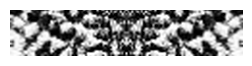


--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [51845.75658766975]
Mean FoM: 51845.756588
Binarization degree: 0.3514


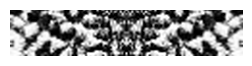


--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [58345.36737936202]
Mean FoM: 58345.367379
Binarization degree: 0.3637


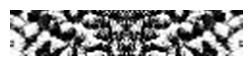


--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [56153.20840907355]
Mean FoM: 56153.208409
Binarization degree: 0.3759


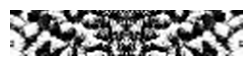


--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [53225.48326429128]
Mean FoM: 53225.483264
Binarization degree: 0.3872


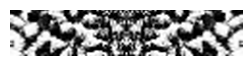


--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [61665.559979539765]
Mean FoM: 61665.559980
Binarization degree: 0.3966


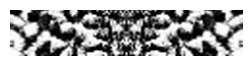


--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [55687.03953683514]
Mean FoM: 55687.039537
Binarization degree: 0.4052


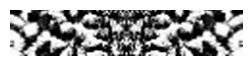


--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [67830.16894137526]
Mean FoM: 67830.168941
Binarization degree: 0.4131


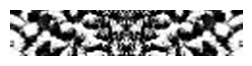


--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [52661.95350574115]
Mean FoM: 52661.953506
Binarization degree: 0.4204


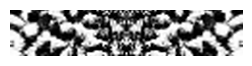


--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [46112.32599532924]
Mean FoM: 46112.325995
Binarization degree: 0.4274


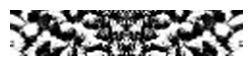


--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [48007.02345981148]
Mean FoM: 48007.023460
Binarization degree: 0.4335


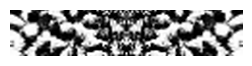


--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [62701.536720057906]
Mean FoM: 62701.536720
Binarization degree: 0.4388


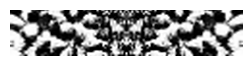


--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [69137.40447846561]
Mean FoM: 69137.404478
Binarization degree: 0.4438


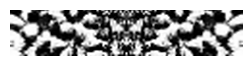


--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [64976.33258624995]
Mean FoM: 64976.332586
Binarization degree: 0.4490


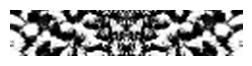


--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [67600.0987735645]
Mean FoM: 67600.098774
Binarization degree: 0.4541


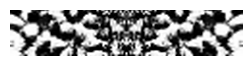


--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [68389.63818033942]
Mean FoM: 68389.638180
Binarization degree: 0.4591


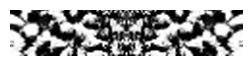


--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [70729.19576313713]
Mean FoM: 70729.195763
Binarization degree: 0.4639


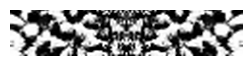


--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [67462.6423994093]
Mean FoM: 67462.642399
Binarization degree: 0.4686


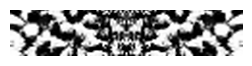


--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [68367.28104554488]
Mean FoM: 68367.281046
Binarization degree: 0.4729


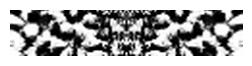


--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [67115.8460714925]
Mean FoM: 67115.846071
Binarization degree: 0.4769


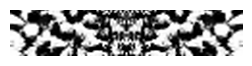


--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [68518.15027599597]
Mean FoM: 68518.150276
Binarization degree: 0.4806


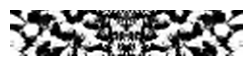


--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [68434.24474272243]
Mean FoM: 68434.244743
Binarization degree: 0.4843


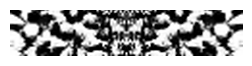


--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [71553.72619263934]
Mean FoM: 71553.726193
Binarization degree: 0.4878


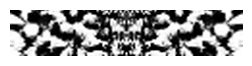


--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [76516.76332082042]
Mean FoM: 76516.763321
Binarization degree: 0.4911


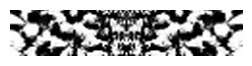


--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [77014.17641939977]
Mean FoM: 77014.176419
Binarization degree: 0.4944


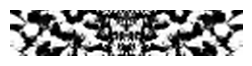


--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [77696.91255719283]
Mean FoM: 77696.912557
Binarization degree: 0.4976


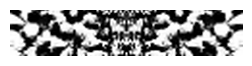


--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [78407.75373343944]
Mean FoM: 78407.753733
Binarization degree: 0.5006


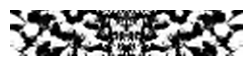


--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.000
FoM values: [75044.53903933518]
Mean FoM: 75044.539039
Binarization degree: 0.5035


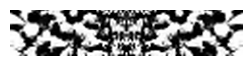


--- Iter 42 ---
Starting forward run...
Starting adjoint run...


KeyboardInterrupt: 

In [376]:
n = Nx * Ny
np.random.seed(4)           
x = 0.4 + 0.2 * np.random.rand(n)  
# x = np.ones(n)*0.5

cur_beta = 6

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

# optimizers = [AdamOptimizer(lr=0.005, beta1=0.8) for _ in range(layer_num)]
optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    # β 전환 감지
    beta_changed = (len(beta_history) > 0 and beta != beta_history[-1])
    beta_prev = beta_history[-1] if beta_changed else beta

    # 현재/이전 β에서의 매핑
    rho_full = free_mapping(v, eta, beta)
    
    if beta_changed:
        rho_old = free_mapping(v, eta, beta_prev)

    # 이진화도 기록
    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny

    # --- FoM/그래디언트 계산: β 바뀐 경우 '값/민감도' 50:50 혼합 ---
    f0_list, dJ_list = [], []
    for i in range(len(opt_list)):
        if beta_changed:
            f_new, dJ_new = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
            f_old, dJ_old = opt_list[i]([rho_old],  need_value=True, need_gradient=True, beta=beta_prev)
            f0_list.append(0.5*(f_new.flatten() + f_old.flatten()))
            dJ_list.append(0.5*(dJ_new + dJ_old))
        else:
            f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
            f0_list.append(f0_i.flatten()); dJ_list.append(dJ_i)


    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    if beta_changed:
        g_new = tensor_jacobian_product(free_mapping, 0)(v, eta, beta,      dJ_flat)
        g_old = tensor_jacobian_product(free_mapping, 0)(v, eta, beta_prev, dJ_flat)
        gradient_full = 0.5*(g_new + g_old)
    else:
        gradient_full = tensor_jacobian_product(free_mapping, 0)(v, eta, beta, dJ_flat)

    g_norm = np.linalg.norm(gradient_full.ravel()) / np.sqrt(gradient_full.size) + 1e-12
    gradient_full = gradient_full / g_norm

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

        if not hasattr(optimizers[i], "base_lr"):
            optimizers[i].base_lr = optimizers[i].lr
        if optimizers[i].lr < optimizers[i].base_lr:
            optimizers[i].lr = min(optimizers[i].base_lr, optimizers[i].lr * 1.25)

    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    update_beta(evaluation_history, binarization_history, beta)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")
    print(f"Binarization degree: {bin_deg:.4f}")

    plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 100

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.6:
        print("Threshold reached → final mapping with β=∞")
        # x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 78407.753733 는 iteration 40 에서 나왔습니다.


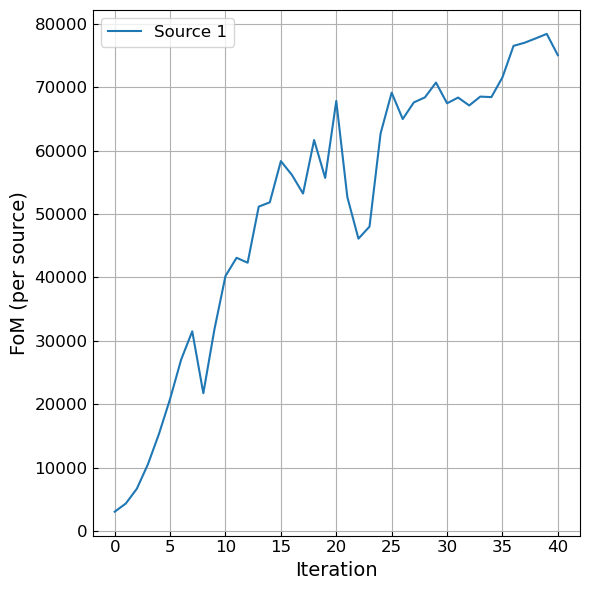

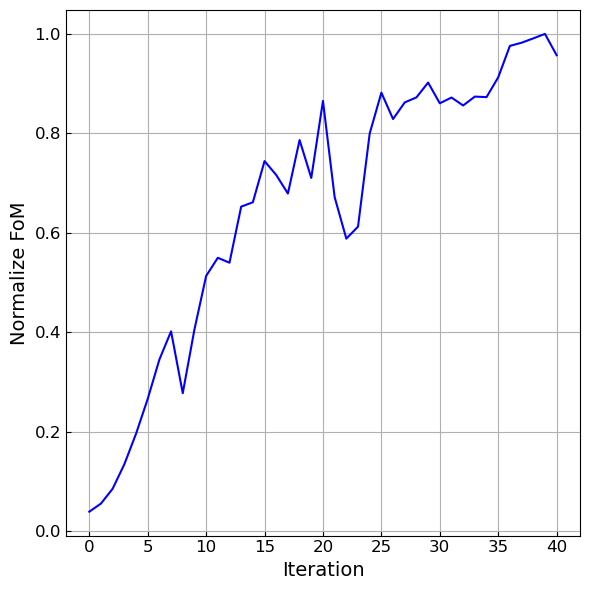

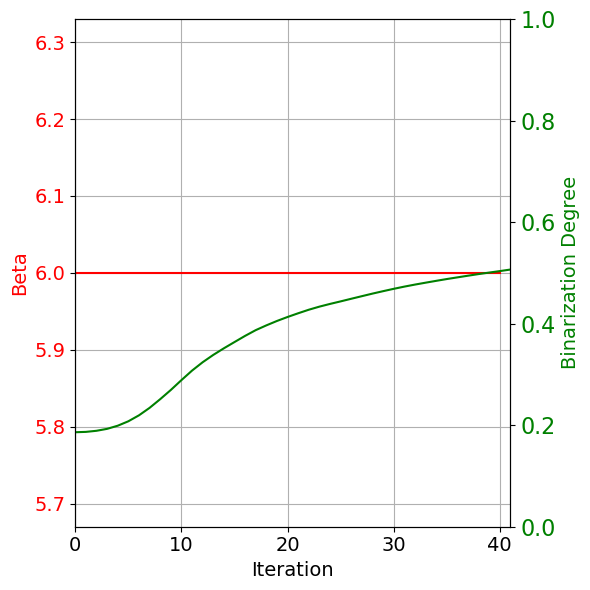

In [377]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Normalize FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

In [ ]:
# k = design_variables.weights
# np.savetxt("Objective45_BEST.txt", k) 

# k = np.loadtxt("Objective45_BEST.txt")
# opt_list[0].update_design([k])

In [ ]:
# # k = design_variables.weights
# # np.savetxt("Objective45_Free.txt", k) 

# k = np.loadtxt("Objective45_Free.txt")
# opt_list[0].update_design([k])

In [ ]:
# k = design_variables.weights
# np.savetxt("Objective45_Free_change.txt", k) 

# k = np.loadtxt("Objective45_Free_change.txt")
# opt_list[0].update_design([k])

In [388]:
# k = design_variables.weights
# np.savetxt("example.txt", k) 

k = np.loadtxt("example.txt")
opt_list[0].update_design([k])

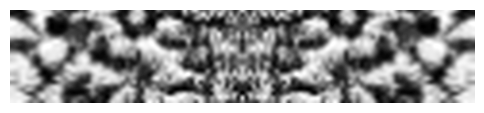

In [389]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
opt_list[0].plot2D(
    False,
    output_plane=mp.Volume(
        size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
        center=mp.Vector3(0, full_center_y, 0)
    ),
    ax=ax,
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
ax.axis("off")
plt.show()

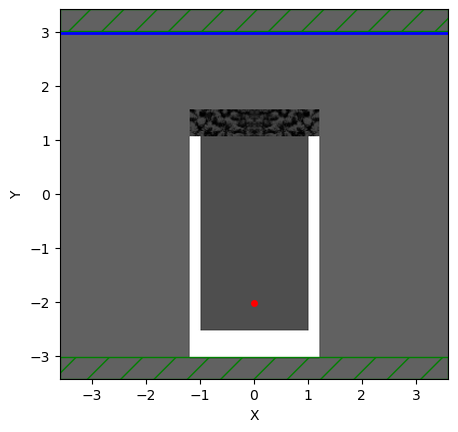

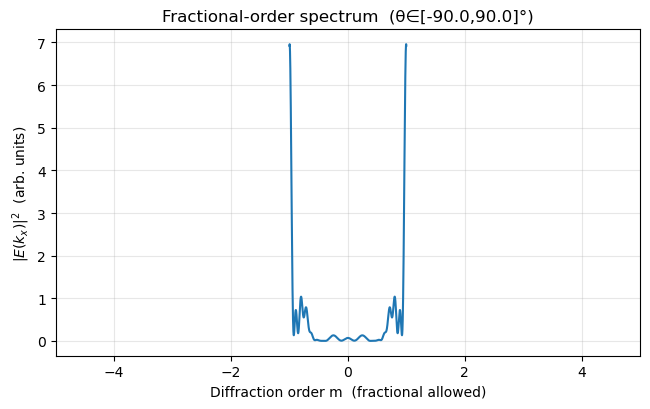

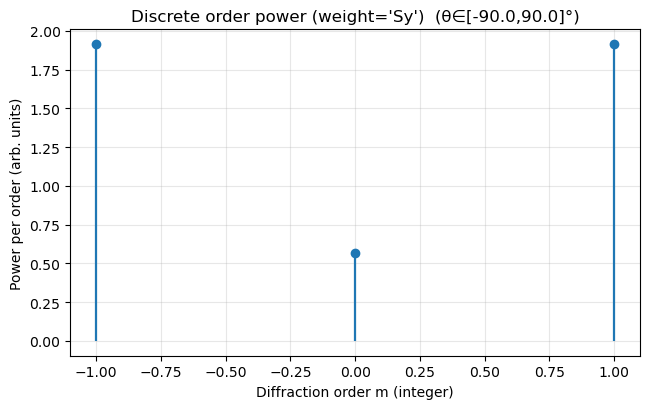

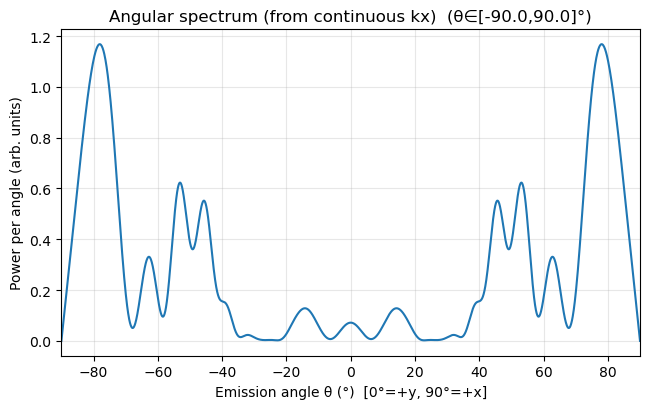

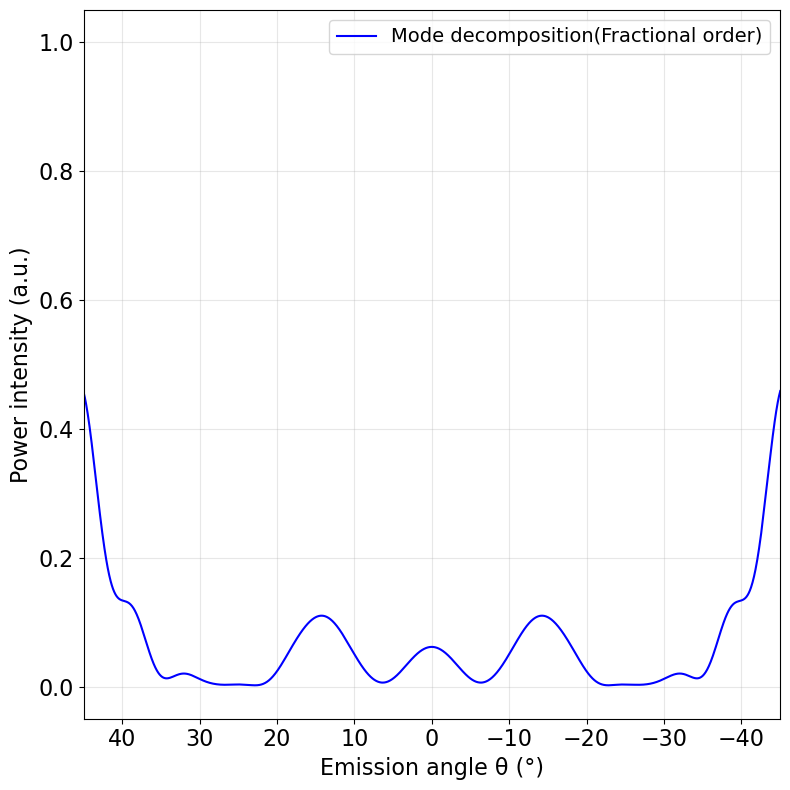

In [390]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

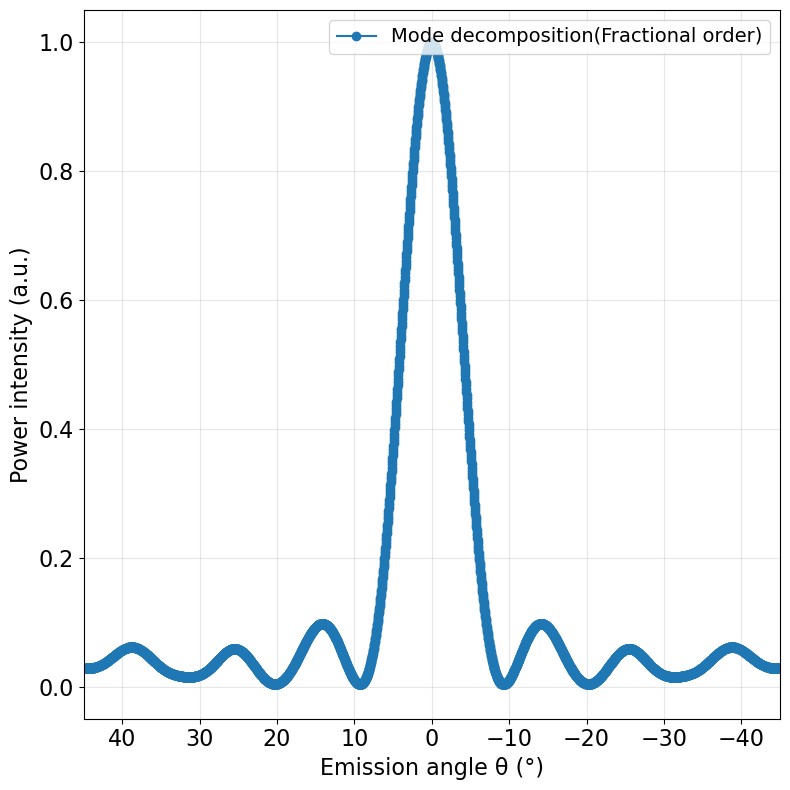

In [187]:

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'o-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

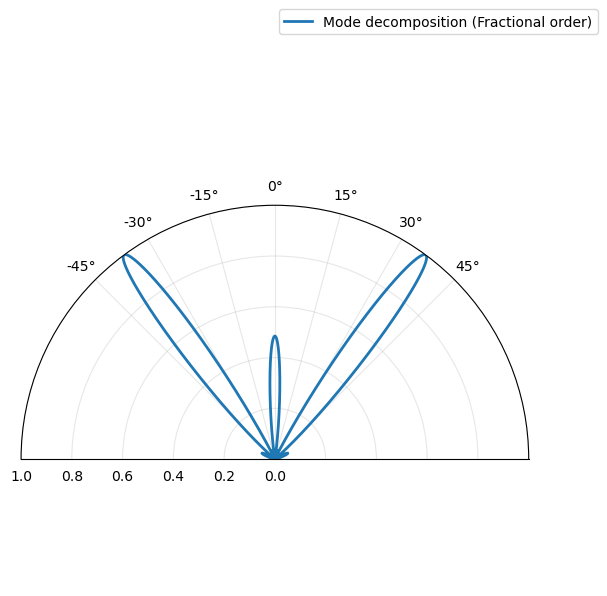

In [327]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()

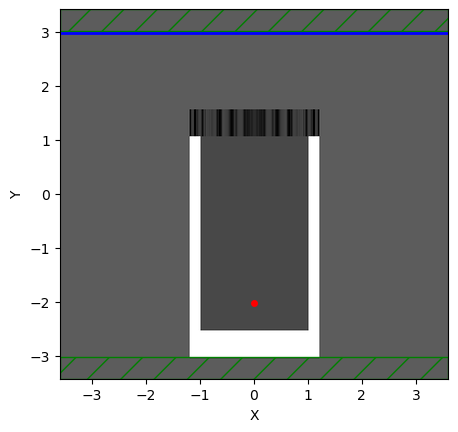

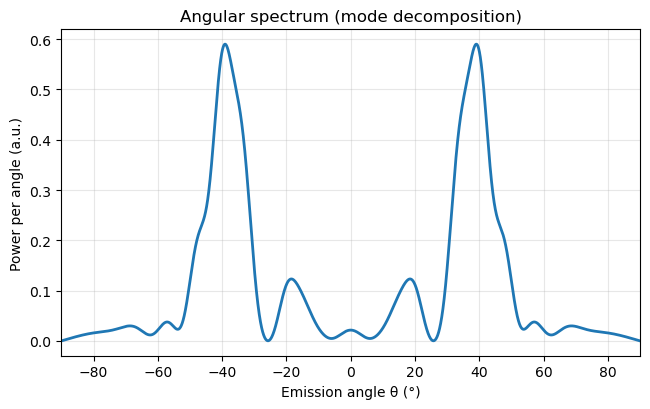

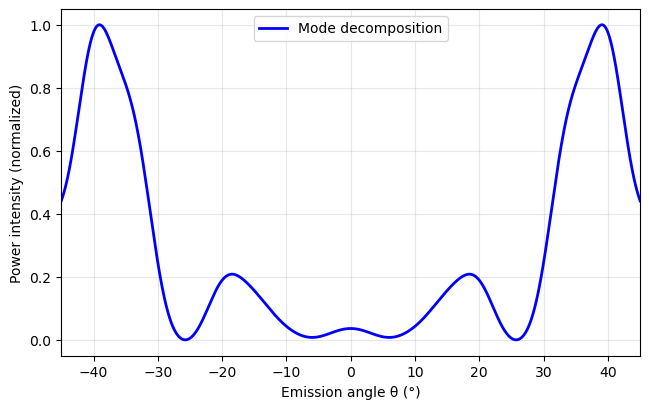

In [258]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

# ========================= Mode-decomposition postproc =========================
import numpy as np
import matplotlib.pyplot as plt

# ----------------------- 설정 -----------------------
use_window   = True
win_kind     = 'tukey'      # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'         # 'none' or 'Sy' (법선 플럭스 가중 = Re(kz/k_out))

# 모니터가 있는 매질 굴절률 (공기=1.0, SiO2≈1.45 등)
n_out = 1.0

# 각도 마스크 (확인하고 싶은 각도 범위)
USE_ANGLE_MASK = True
theta_min_deg  = 0.0        # 예: 0~45° 총전력
theta_max_deg  = 45.0

# (선택) 주기 Λx가 있을 때만 정수 차수 파워 계산. 없으면 None
Lambda_x = None             # 예: 0.5  (단위: µm). 없으면 None

# ----------------------- 데이터/격자 -----------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
L  = float(monitor_size.x)              # 라인 모니터 길이
dx = L / N
x  = (np.arange(N) - N/2) * dx

# 창 함수
def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w      = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)
Ez_win = Ez * w

# 파수/각도 축 (모니터 매질 기준)
k0    = 2*np.pi*float(fcen)
k_out = n_out * k0
kx_grid   = np.linspace(-k_out, +k_out, Nkx)
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k_out, -1, 1)))

# 연속 kx DFT (중심 위상 정렬)
Ckx = dx * np.sum(Ez_win[:, None] * np.exp(-1j * x[:, None] * kx_grid), axis=0)
USE_ANGLE_MASK = False           # ← True → False

# 각도 마스크
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

kx_masked    = kx_grid[ang_mask]
Ckx_masked   = Ckx[ang_mask]
theta_masked = theta_all[ang_mask]

# 각도별 전력 스펙트럼 (논문식: |C|^2 * Re(kz/k_out); 공기면 cosθ)
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0.0, 1.0 - (kx_masked/k_out)**2))
else:
    P_theta = np.abs(Ckx_masked)**2

# ----------------------- 플롯 1: 연속 각도 스펙트럼 -----------------------
plt.figure(figsize=(6.6, 4.2))
plt.plot(theta_masked, P_theta, lw=2)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)")
plt.ylabel("Power per angle (a.u.)")
plt.title("Angular spectrum (mode decomposition)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------- (선택) 정수 차수 파워 -----------------------
if Lambda_x is not None:
    G = 2*np.pi / float(Lambda_x)                  # 역격자 크기
    m_max  = int(np.floor(k_out / G + 1e-12))
    m_list = np.arange(-m_max, m_max+1)

    Pk = []
    dk = kx_grid[1] - kx_grid[0]
    for m_int in m_list:
        k_lo = (m_int - 0.5) * G
        k_hi = (m_int + 0.5) * G
        k_lo = max(k_lo, -k_out)
        k_hi = min(k_hi, +k_out)
        if k_hi <= k_lo:
            Pk.append(0.0); continue

        sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
        if not np.any(sel):
            Pk.append(0.0); continue

        if weight.lower() == 'sy':
            kz = np.sqrt(np.maximum(k_out**2 - kx_grid[sel]**2, 0.0))
            P_m = np.sum(np.abs(Ckx[sel])**2 * (kz/(k_out + 1e-18))) * dk
        else:
            P_m = np.sum(np.abs(Ckx[sel])**2) * dk
        Pk.append(float(P_m))

    Pk = np.array(Pk, dtype=float)

    plt.figure(figsize=(6.6, 4.2))
    plt.vlines(m_list, 0.0, Pk, colors='C0', lw=1.6)
    plt.plot(m_list, Pk, 'C0o', ms=6)
    plt.xlabel("Diffraction order m (integer)")
    plt.ylabel("Power per order (a.u.)")
    title_mask = f"θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°" if USE_ANGLE_MASK else "θ∈[-90,90]°"
    plt.title(f"Discrete order power  ({title_mask}, weight='{weight}')")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ----------------------- (참고) 정규화된 선형 플롯 -----------------------
plt.figure(figsize=(6.6, 4.2))
P_norm = P_theta / (np.max(P_theta) + 1e-15)
plt.plot(theta_masked, P_norm, 'b-', lw=2, label='Mode decomposition')
plt.xlim(-45, 45)
plt.xlabel("Emission angle θ (°)")
plt.ylabel("Power intensity (normalized)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

최대 FoM = 15930.859671 는 iteration 149 에서 나왔습니다.


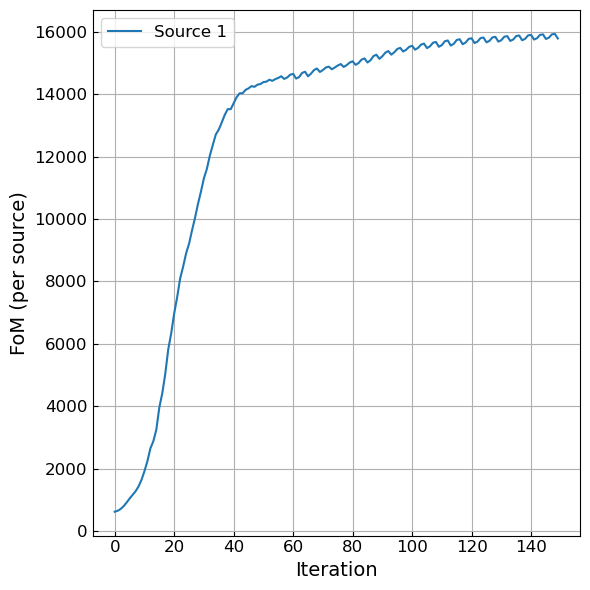

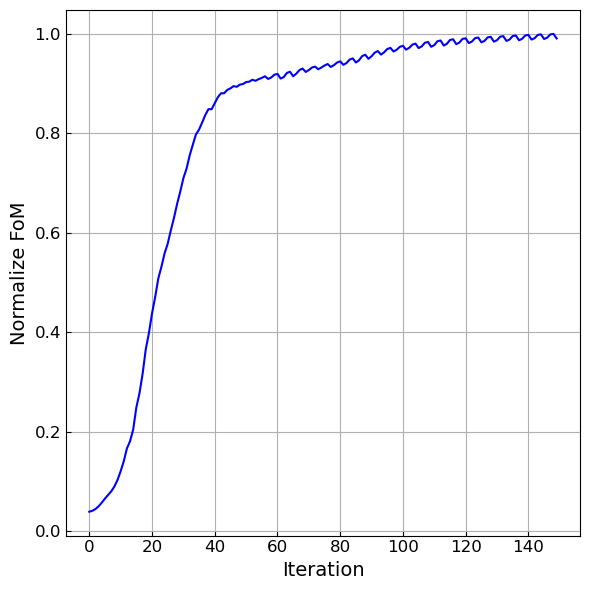

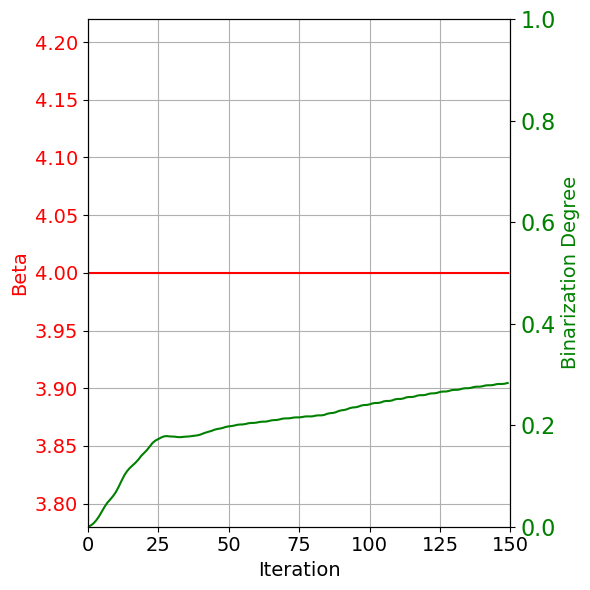

In [71]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Normalize FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

최대 FoM = 15467.690055 는 iteration 114 에서 나왔습니다.


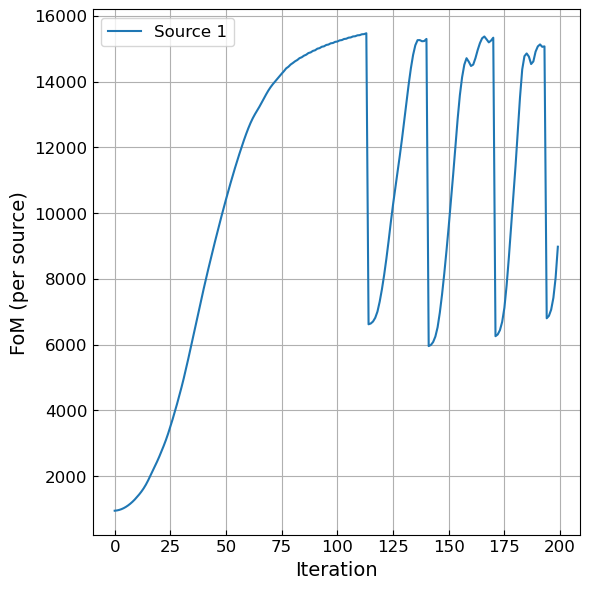

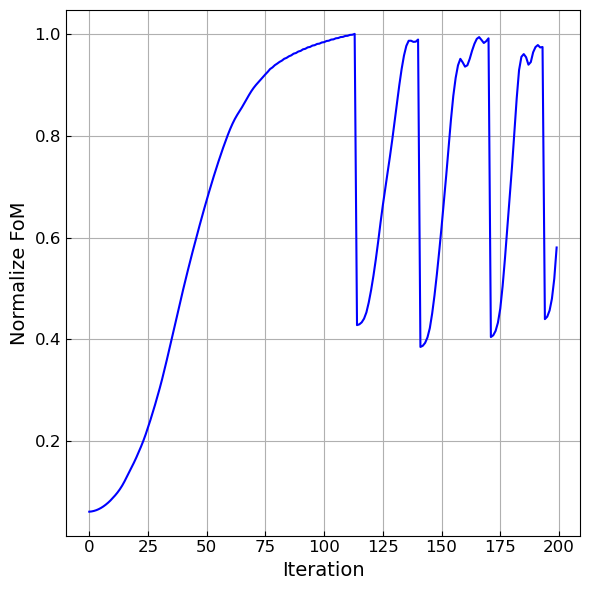

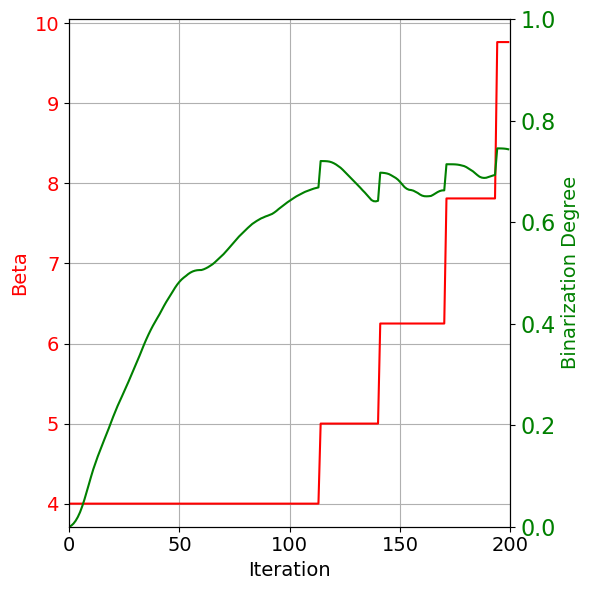

In [ ]:
# ################ Find best FOM ################ 
# eval_hist = np.array(evaluation_history)
# max_val   = eval_hist.max()
# max_idx0  = eval_hist.argmax()
# iteration = max_idx0 + 1

# print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

# ################ FOM plot ################ 
# evaluation_array = np.array(evaluation_history)  
# iterations = np.arange(len(evaluation_history))

# ###################### [1] 각 소스별 FoM plot ######################
# plt.figure(figsize=(6, 6))

# for i in range(evaluation_array.shape[1]):  # 각 소스별
#     plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

# plt.xlabel('Iteration', fontsize=14)
# plt.ylabel('FoM (per source)', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tick_params(direction='in')
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.tight_layout()
# plt.show()

# ###################### [2] 평균 FoM plot ######################
# plt.figure(figsize=(6, 6))

# mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
# plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

# plt.xlabel('Iteration', fontsize=14)
# plt.ylabel('Normalize FoM', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tick_params(direction='in')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# ################ Combined Beta and Binarization Degree Plot ################ 
# fig, ax1 = plt.subplots(figsize=(6,6))

# color1 = 'red'
# ax1.set_xlabel('Iteration', fontsize=14)
# ax1.set_ylabel('Beta', color=color1, fontsize=14)
# ax1.plot(beta_history, color=color1, label='Beta History')
# ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_xlim(0, np.array(cur_iter))
# ax1.tick_params(labelsize=14)
# ax1.grid(True)

# ax2 = ax1.twinx()
# color2 = 'green'
# ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
# ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
# ax2.tick_params(axis='y', labelcolor=color2)
# ax2.set_ylim(0.4, 1)
# ax2.set_ylim(0, 1)
# ax2.tick_params(labelsize=16)

# fig.tight_layout()
# # plt.title('Beta & Binarization Degree', fontsize=15)
# plt.show()

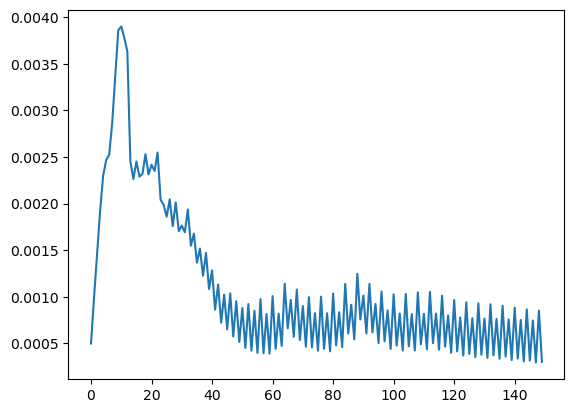

In [95]:
plt.plot(np.array(lr_histories)[0])

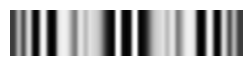

In [72]:
plt.figure(figsize=(3, 2))
ax = plt.gca()
opt_list[0].plot2D(
    False,
    output_plane=mp.Volume(
        size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
        center=mp.Vector3(0, full_center_y, 0)
    ),
    ax=ax,
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
ax.axis("off")
plt.show()

In [ ]:
# k = design_variables.weights
# np.savetxt("Objective45.txt", k) 

In [89]:
k = np.loadtxt("Objective45.txt")
opt_list[0].update_design([k])

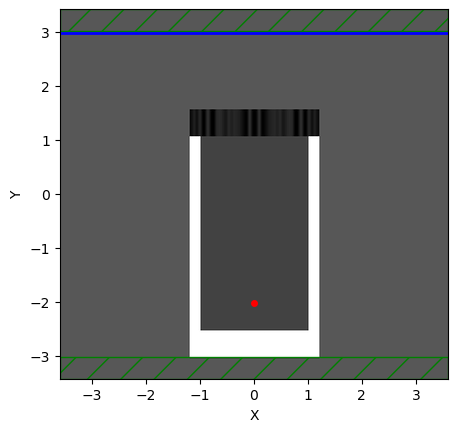

In [90]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

In [91]:
opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

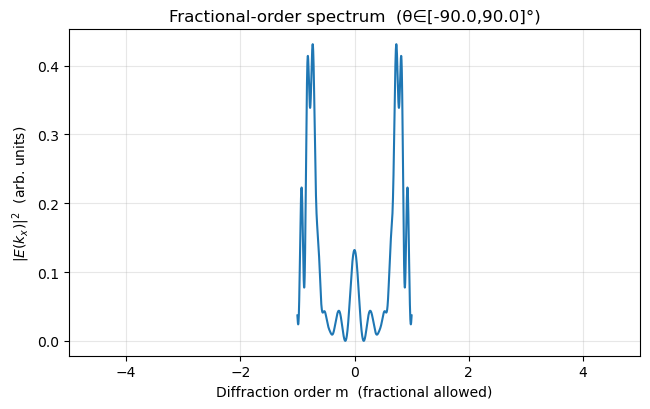

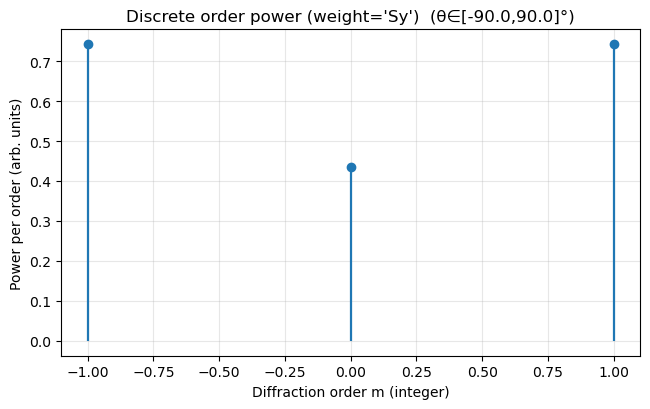

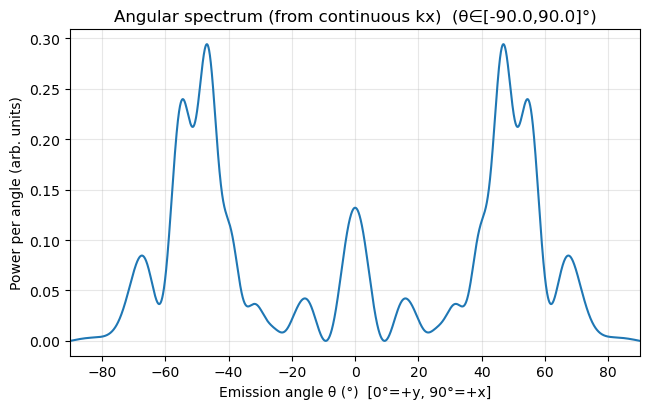

In [92]:
# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================


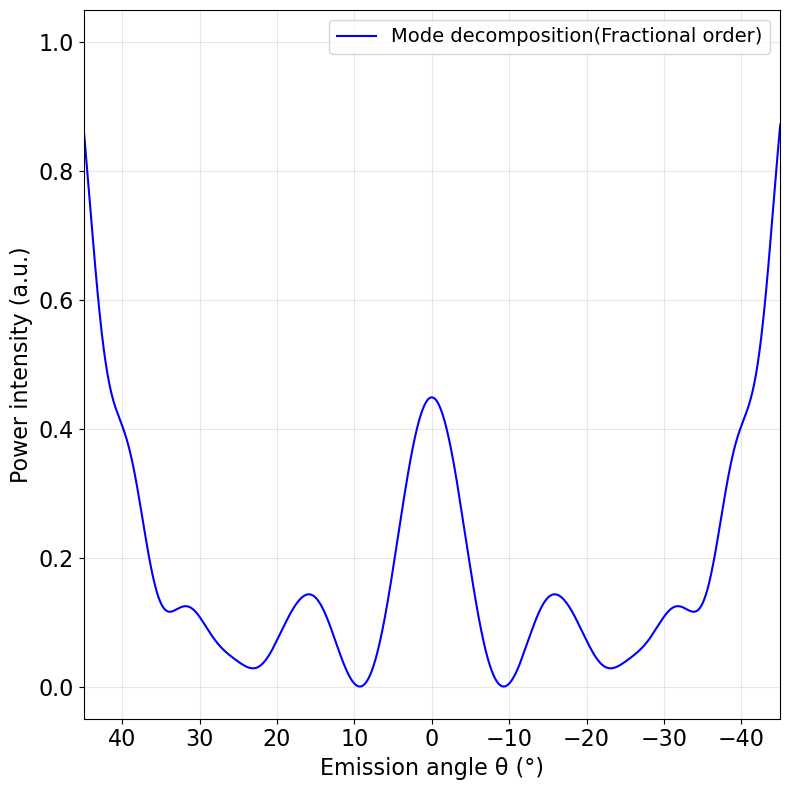

In [93]:
plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

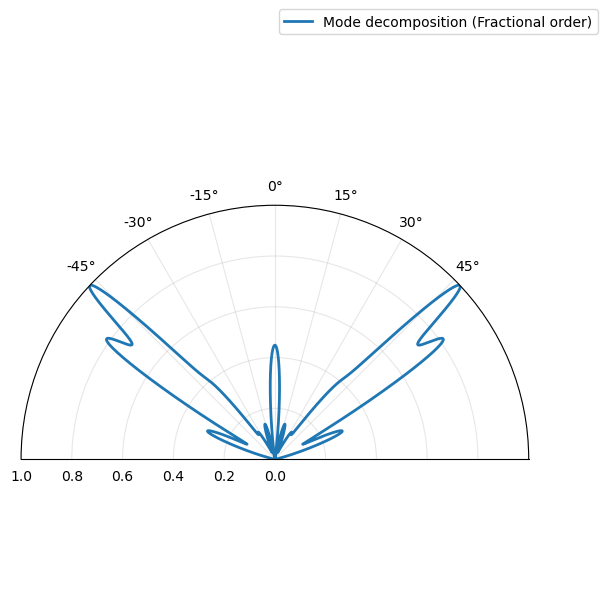

In [94]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()

In [118]:
Pr_sel = [0.0107073 , 0.00997911, 0.00929179, 0.00858321, 0.00785196,
       0.00722387, 0.00693566, 0.00724677, 0.00835336, 0.01038169,
       0.01347349, 0.01789102, 0.02403943, 0.03236102, 0.04316205,
       0.0564946 , 0.07217363, 0.08989717, 0.10936095, 0.13028385,
       0.15235092, 0.17514219, 0.19810081, 0.22053809, 0.24164224,
       0.26047998, 0.27603237, 0.28733134, 0.29371606, 0.2951224 ,
       0.29224894, 0.2864981 , 0.27973519, 0.27399191, 0.27119093,
       0.27288426, 0.28001228, 0.2927724 , 0.31069091, 0.33286859,
       0.35826124, 0.38590484, 0.41512142, 0.44574314, 0.4782618 ,
       0.51376432, 0.55364272, 0.59920532, 0.6512954 , 0.70989836,
       0.77367305, 0.83946941, 0.90209251, 0.95463614, 0.9895187 ,
       1.        , 0.98168908, 0.93357025, 0.85832738, 0.76198554,
       0.65296501, 0.54066679, 0.43384086, 0.33915452, 0.26035653,
       0.19818285, 0.15089904, 0.11529506, 0.08794246, 0.06642097,
       0.05008402, 0.03999509, 0.0380118 , 0.04541254, 0.06166677,
       0.08385958, 0.10702342, 0.12534793, 0.13396979, 0.13080257,
       0.11774194, 0.10069413, 0.08824102, 0.08923717, 0.11003104,
       0.15216666, 0.21131345, 0.27783662, 0.33894995, 0.38191171,
       0.39737496, 0.38191171, 0.33894995, 0.27783662, 0.21131345,
       0.15216666, 0.11003104, 0.08923717, 0.08824102, 0.10069413,
       0.11774194, 0.13080257, 0.13396979, 0.12534793, 0.10702342,
       0.08385958, 0.06166677, 0.04541254, 0.0380118 , 0.03999509,
       0.05008402, 0.06642097, 0.08794246, 0.11529506, 0.15089904,
       0.19818285, 0.26035653, 0.33915452, 0.43384086, 0.54066679,
       0.65296501, 0.76198554, 0.85832738, 0.93357025, 0.98168908,
       1.        , 0.9895187 , 0.95463614, 0.90209251, 0.83946941,
       0.77367305, 0.70989836, 0.6512954 , 0.59920532, 0.55364272,
       0.51376432, 0.4782618 , 0.44574314, 0.41512142, 0.38590484,
       0.35826124, 0.33286859, 0.31069091, 0.2927724 , 0.28001228,
       0.27288426, 0.27119093, 0.27399191, 0.27973519, 0.2864981 ,
       0.29224894, 0.2951224 , 0.29371606, 0.28733134, 0.27603237,
       0.26047998, 0.24164224, 0.22053809, 0.19810081, 0.17514219,
       0.15235092, 0.13028385, 0.10936095, 0.08989717, 0.07217363,
       0.0564946 , 0.04316205, 0.03236102, 0.02403943, 0.01789102,
       0.01347349, 0.01038169, 0.00835336, 0.00724677, 0.00693566,
       0.00722387, 0.00785196, 0.00858321, 0.00929179, 0.00997911,
       0.0107073 ]
angle_sel = [
    -90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
       -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
       -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
       -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
       -46., -45., -44., -43., -42., -41., -40., -39., -38., -37., -36.,
       -35., -34., -33., -32., -31., -30., -29., -28., -27., -26., -25.,
       -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
       -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
        -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,
        20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,
        53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,
        64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
        86.,  87.,  88.,  89.,  90.
]

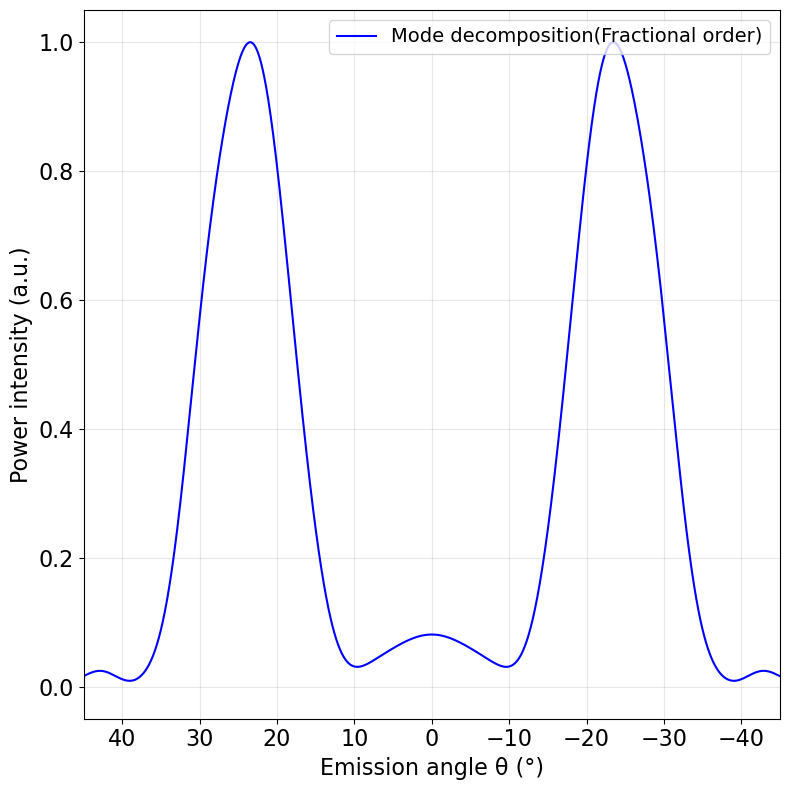

In [64]:
plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

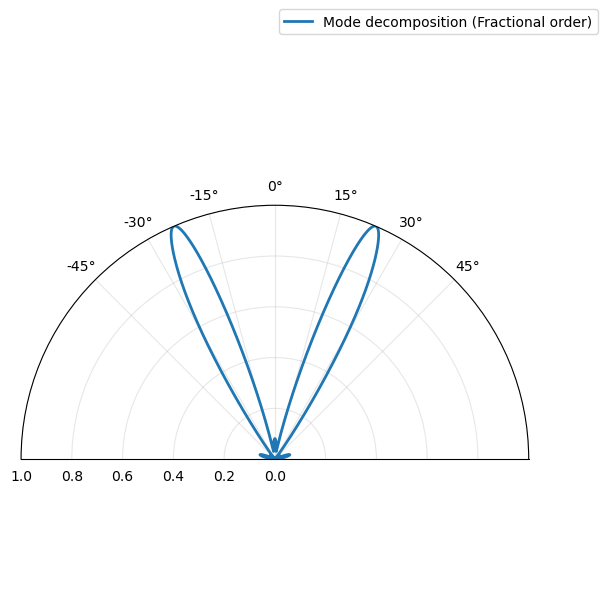

In [66]:
th1 = np.radians(theta_masked)
y1  = P_theta / np.max(P_theta)

# th2 = np.radians(angle_sel)
# y2  = Pr_sel / np.max(Pr_sel)  # 이미 정규화되어 있으면 생략

fig = plt.figure(figsize=(7,6))
ax  = fig.add_subplot(111, projection='polar')

# 각도 기준/방향 설정
ax.set_theta_zero_location('N')   # 0°를 위쪽으로
ax.set_theta_direction(-1)        # 시계 방향으로 증가

# 반폴라 범위: −45° ~ +45°
ax.set_thetamin(-90)
ax.set_thetamax(90)
# (버전에 따라) ax.set_thetalim(np.radians((-45, 45))) 사용 가능

# 곡선 플롯
ax.plot(th1, y1, label='Mode decomposition (Fractional order)', linewidth=2)
# ax.plot(th2, y2, label = 'N2F - 360 points', linewidth=2)

# 반경 범위/눈금
ax.set_rlim(0, 1)
ax.set_thetagrids(range(-45, 46, 15))
ax.grid(True, alpha=0.3)

ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()